In [1]:
# Libraries to access external data
# PyVO provides generic access to VO protocols (ex: TAP)
import pyvo
# astroquery modules are specific to astronomy services, there are not necessarily VO,
# but more and more do switch to using VO protocols behind the scenes these days
# here we import the MOCServer and Vizier modules
from astroquery.mocserver import MOCServer

# The mocpy library is an astropy-affiliated library
# It allows to manipulate MOCs
from mocpy import STMOC, MOC, TimeMOC

# General astropy utility methods and classes
from astropy.coordinates import Longitude, Latitude, Angle, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u

# For visualization
import matplotlib.pyplot as plt
from ipyaladin import Aladin


# Accessing data through space and time criteria

## This notebook focuses on the use of the Multi-Order Coverage (MOC) and Space-Time MOC (STMOC) for querying and analyzing astronomical data. 

### Key words:

**Hierarchical Progressive Survey (HiPS)**: HiPS describes a generic method for packaging, storing, querying, and describing astronomical data. It stores data in a folder structure that mimics the [HEALPix tesselation of the sky](https://healpix.jpl.nasa.gov/pdf/intro.pdf).

**Multi-Order Coverage (MOC)**: MOC is a data structure used to describe arbitrary regions of the sky with variable resolution. It is particularly useful for handling large-scale astronomical surveys and for efficiently querying regions of interest.

**Space-Time MOC (STMOC)**: STMOC extends the concept of MOC to include the temporal dimension, allowing for the representation of regions of the sky that change over time. This is useful for time-domain astronomy, where the visibility of sources varies.

### Scientific Motivation:

Gamma-Ray Bursts (GRBs) are among the most energetic and mysterious phenomena in the universe. These brief but intense flashes of gamma rays are believed to originate from cataclysmic events such as the collapse of massive stars or the merger of neutron stars. Observing GRBs across multiple wavelengths and with different telescopes provides crucial insights into their nature and origins. In this study, we focus on GRBs observed by the Fermi Gamma-ray Space Telescope and the XMM-Newton X-ray Observatory, and demonstrate how the use of Space-Time Multi-Order Coverage (STMOC) can help identify and analyze these fascinating events.

## The HEALPix grid and its link to HiPS surveys

HiPS is a way of storing data sets (it can be catalogs, or images for example) that follows the HEALPix tesselation of the sky. This is particularly optimized for visualization.

![HiPS_and_the_HEALPix_grid](HiPS_and_the_HEALPix_grid.png)

Figure 1: Standards to represent the sky, or parts of the sky. (a) The HEALPix grid (b) The HiPS standard (c) Visualization in ipyaladin (d), and a MOC.

### The HEALPix grid

With the HEALPix grid, the sphere is mapped by equal-area tiles. In **Figure 1a**, we show an orthographic representation of the 12 tiles at order zero and of the 768 tiles at order 3. This is extracted from [Gorski *et.al.*](https://iopscience.iop.org/article/10.1086/427976/pdf).

`mocpy` is a python library that allows to manipulate MOCs. MOCs are made of HEALPix cells (see **Figure 1d** and the next parts where we'll look at MOCs in more details), so mocpy has a few methods that allow to get information about the HEALPix tesselation.

In [2]:
# we can check the number of cells at order 0 in the HEALPix tesselation
MOC.n_cells(0)

12

In [3]:
# or at an other order
MOC.n_cells(3)

768

In [4]:
# we could also have calculated the order 3 by knowing that
# each cell is subdivised in four parts at the next order
n_cells_order3 = MOC.n_cells(0) * 4**3
n_cells_order3

768

Let's visualize the HEALPix grid in the ipyaladin widget, see **Figure 1c** to see where to find the parameter. If you zoom in and out and move like crazy (or if you have a slower internet connection), you'll see the images that appear as they are downloaded by ipyaladin. They have the shape of HEALPix cells. The more you zoom in, the more precise (meaning higher resolution) the printed image will be.

In [5]:
aladin = Aladin()
aladin

Aladin(init_options=['_fov', '_target', 'background_color', 'coo_frame', 'full_screen', 'grid_color', 'grid_op…

We can duplicate this view by right clicking on the cell and selecting `Create new view for cell output`. The view can then be dragged anywhere you prefer. This allows to always have an eye on the widget while exploring the data.
In the `Output View`, it is also quite nice to use the `fullscreen` button, the one in the top right corner of the widget.

If you zoom in **a lot**, you will see that the pixels correspond to the tiles of the HEALPix grid at order 18 for the DSS survey that is displayed by default in `ipyaladin`. You can find out which resolution it corresponds to with an other of `mocpy`'s methods:

In [6]:
MOC.order_to_spatial_resolution(18)

<Angle 3.90368159e-06 rad>

Which we can also convert to arcseconds (or any other angle unit, try it out!)

In [7]:
MOC.order_to_spatial_resolution(18).to("arcsec")

<Angle 0.80519213 arcsec>

### The HiPS standard

The images displayed by Aladin follow the HiPS standard, in which a folder corresponds to a HEALPix order, see **figure1b**. In figure 1b, the example images are from a SDO/AIA observation of the Sun. At all orders, the images have the same number of pixels (here 512*512), but they represent a different sky fraction. On the figure, we see that the pixel 0 at order 3 contains the pixel 0 and 1 of the more precise order.

### Finding HiPS surveys

#### Fermi

More and more astronomical data centers start to offer HiPS surveys for sky visualizations.

One way of finding HiPS surveys is to use `ipyaladin`'s interface, see **Figure2**, and follow the steps to get the two MeerKAT HiPS.

![finding_HiPS](finding_hips_with_ipyaladin.png)
**Figure 2**: Finding a HiPS with `ipyaladin`'s interface.

Nothing appears? Let's move the target to the galactic center and zoom in a bit:

In [8]:
aladin.target = "Galactic Center"
aladin.fov = Angle(5, unit="deg") # the Angle object is from astropy

And you should see the MeerKat survey! 

Note that `fov`, the field of view argument, fixes the angle on the x axis.

#### Finding HiPS programmatically

The `Browse HiPS` button calls one of the less known services of the CDS, the MOCServer. Its name is a bit misleading, as it does not only hosts MOCs, but also HiPSs. The search bar in `ipyaladin` only works if you already know more or less the name of the survey. For more control on search parameters, we will use the module `mocserver` from the `astroquery` library that give a direct access the the [MOCServer](https://astroquery.readthedocs.io/en/latest/mocserver/mocserver.html#module-astroquery.mocserver).

Here we query the MOC server to find HiPS datasets related to Fermi observations. Fermi cameras are sensitive to sources that emit in gamma-rays. GRBs are the ideal candidate for Fermi.

In [9]:
fermi_hips = MOCServer.find_datasets(meta_data="obs_description=*Fermi*&&hips_*=*", casesensitive=False)
#fermi_hips

In [10]:
len(fermi_hips)

9

We found nine HiPS surveys with the word `Fermi` in their descriptions. The object that we got from astroquery is a table containing information about the HiPS surveys. Let's inspect its column names to see what it contains.

In [11]:
fermi_hips.colnames

['creator_did',
 'client_category',
 'hips_creation_date',
 'obs_copyright_url',
 'hips_doi',
 'dataproduct_type',
 't_min',
 'obs_regime',
 'hips_pixel_scale',
 'hips_initial_ra',
 'moc_type',
 'hips_initial_fov',
 'obs_initial_ra',
 'hips_order_min',
 'obs_ack',
 'hipsgen_params_3',
 'obs_initial_fov',
 'hips_rgb_blue',
 'hips_rgb_green',
 'obs_description',
 'hips_service_url_3',
 'bib_reference',
 'hips_builder',
 'hips_initial_dec',
 'hips_rgb_red',
 'moc_access_url',
 'hipsgen_params_1',
 'hips_pixel_cut',
 'moc_time_range',
 'bib_reference_url',
 'client_sort_key',
 'hips_estsize',
 'hips_release_date',
 'ID',
 'hips_status_2',
 'moc_time_order',
 'hips_service_url',
 'moc_sky_fraction',
 'hipsgen_date',
 'client_application',
 'hipsgen_params_2',
 'hips_creator',
 'hips_version',
 'hips_tile_width',
 'hipsgen_params',
 'hips_service_url_1',
 'em_max',
 'em_min',
 'TIMESTAMP',
 'hips_data_range',
 'hips_status_3',
 'hips_frame',
 'moc_order',
 'hips_status_1',
 'hips_copyright',

We can check the descriptions of the surveys, for example

In [12]:
fermi_hips[["obs_description", "ID"]]

obs_description,ID
object,str20
"Launched on June 11, 2008, the Fermi Gamma-ray Space Telescope observes the cosmos using the highest-energy form of light. This survey sums all data observed by the Fermi mission up to week 396. This version of the Fermi survey are intensity maps where the summed counts maps are divided by the exposure for each pixel. We anticipate using the HEASARC's Hera capabilities to update this survey on a roughly quarterly basis. Data is broken into 5 energy bands : 30-100 MeV Band 1, 100-300 MeV Band 2, 300-1000 MeV Band 3, 1-3 GeV Band 4 , 3-300 GeV Band 5. The SkyView data are based upon a Cartesian projection of the counts divided by the exposure maps. In the Cartesian projection pixels near the pole have a much smaller area than pixels on the equator, so these pixels have smaller integrated flux. When creating large scale images in other projections users may wish to make sure to compensate for this effect the flux conserving clip-resampling option.",CDS/P/Fermi/3
"Launched on June 11, 2008, the Fermi Gamma-ray Space Telescope observes the cosmos using the highest-energy form of light. This survey sums all data observed by the Fermi mission up to week 396. This version of the Fermi survey are intensity maps where the summed counts maps are divided by the exposure for each pixel. We anticipate using the HEASARC's Hera capabilities to update this survey on a roughly quarterly basis. Data is broken into 5 energy bands : 30-100 MeV Band 1, 100-300 MeV Band 2, 300-1000 MeV Band 3, 1-3 GeV Band 4 , 3-300 GeV Band 5. The SkyView data are based upon a Cartesian projection of the counts divided by the exposure maps. In the Cartesian projection pixels near the pole have a much smaller area than pixels on the equator, so these pixels have smaller integrated flux. When creating large scale images in other projections users may wish to make sure to compensate for this effect the flux conserving clip-resampling option.",CDS/P/Fermi/4
"Launched on June 11, 2008, the Fermi Gamma-ray Space Telescope observes the cosmos using the highest-energy form of light. This survey sums all data observed by the Fermi mission up to week 396. This version of the Fermi survey are intensity maps where the summed counts maps are divided by the exposure for each pixel. We anticipate using the HEASARC's Hera capabilities to update this survey on a roughly quarterly basis. Data is broken into 5 energy bands : 30-100 MeV Band 1, 100-300 MeV Band 2, 300-1000 MeV Band 3, 1-3 GeV Band 4 , 3-300 GeV Band 5. The SkyView data are based upon a Cartesian projection of the counts divided by the exposure maps. In the Cartesian projection pixels near the pole have a much smaller area than pixels on the equator, so these pixels have smaller integrated flux. When creating large scale images in other projections users may wish to make sure to compensate for this effect the flux conserving clip-resampling option.",CDS/P/Fermi/5
"Launched on June 11, 2008, the Fermi Gamma-ray Space Telescope observes the cosmos using the highest-energy form of light. This survey sums all data observed by the Fermi mission up to week 396. This version of the Fermi survey are intensity maps where the summed counts maps are divided by the exposure for each pixel. We anticipate using the HEASARC's Hera capabilities to update this survey on a roughly quarterly basis. Data is broken into 5 energy bands : 30-100 MeV Band 1, 100-300 MeV Band 2, 300-1000 MeV Band 3, 1-3 GeV Band 4 , 3-300 GeV Band 5. The SkyView data are based upon a Cartesian projection of the counts divided by the exposure maps. In the Cartesian projection pixels near the pole have a much smaller area than pixels on the equator, so these pixels have smaller integrated flux. When creating large scale images in other projections users may wish to make sure to compensate for this effect the flux conserving clip-resampling option.",CDS/P/Fermi/color
"Fermi-LAT all-sky survey in Band 1 (30-100 MeV), at an angular 

#### XMM-Newton

GRBs can be studied in conjunction with other instruments spanning wide range of wavelengths in order to understand the various properties of the GRB. The bursts of gamma-rays produced by the GRBs collide with each other and also the interstellar medium and produce what we call the "after glow". The "after glow" contains electromagnetic radiations ranging from X-rays to radio. Let's explore the GRBs also detected in X-rays. As shown above, we can obtain HiPs for the XMM-Newton Telescope. XMM-Newton is a powerful telescope that observes the X-ray Universe.

We will repeat the process we used to find Fermi HiPS, but for XMM-Newton:

In [13]:
xmm_hips = MOCServer.find_datasets(meta_data="obs_description=*xmm*&&hips_*=*", casesensitive=False)
xmm_hips

hips_nb_tiles,creator_did,client_category,obs_copyright_url,obs_regime,dataproduct_type,hips_initial_ra,t_min,hips_pixel_scale,hips_creation_date,hips_overlay,dataproduct_subtype,hips_initial_fov,obs_initial_ra,hips_order_min,obs_ack,hips_rgb_blue,obs_initial_fov,hips_rgb_green,hips_sampling,obs_description,bib_reference,hips_progenitor_url,hips_builder,hips_initial_dec,hips_rgb_red,hips_pixel_cut,moc_time_range,bib_reference_url,hips_hierarchy,hips_estsize,hips_release_date,hips_check_code,ID,hips_status_2,moc_time_order,hips_service_url,moc_sky_fraction,hipsgen_date,client_application,s_pixel_scale,hips_creator,hips_version,hips_tile_width,hipsgen_params,hips_service_url_1,em_max,em_min,TIMESTAMP,hips_data_range,data_pixel_bitpix,hips_frame,moc_type,hips_status_1,hips_copyright,moc_order,hips_service_url_2,obs_copyright,obs_initial_dec,hips_tile_format,hips_order,hips_pixel_bitpix,prov_progenitor,t_max,hips_status,obs_title,obs_collection
float64,str27,str15,str27,str5,str5,float64,float64,float64,str17,object,str5,float64,float64,float64,str42,str31,float64,str32,object,str153,str19,str43,str22,float64,str30,str13,float64,str64,str6,float64,str17,str30,str21,str24,float64,str33,float64,str17,str10,float64,str38,float64,float64,str214,str55,float64,float64,float64,str18,object,str10,str5,str24,str30,float64,str58,str24,float64,str8,float64,object,str55,float64,str26,str62,str14
--,ivo://xcatdb/P/XMM/PN/color,Image/X-ray/XMM,https://xmmssc.irap.omp.eu/,X-ray,image,23.4621,51577.0,0.0008946,2023-06-05T14:24Z,overlayMean mergeOverwriteTile treeMedian,color,1.0,23.4621,0.0,"Galhecos-Team (Strasbourg), SSC XMM-Newton",test [1.0E-6 NaN 4.0E-4 Linear],0.4580648549089874,green [1.0E-6 NaN 4.0E-4 Linear],--,Colored image made with all PN images of the 4xmmdr12: Red=0.5-1Kev Green=1-2Kev Blue=2-4.5Kev - Healpixilized by Michel L. [Observatoire de Strasbourg],2020A&A...641A.136W,--,Aladin/HipsGen v12.060,30.65994167,red [1.0E-6 NaN 4.0E-4 Linear],--,1.0,https://ui.adsabs.harvard.edu/abs/2020A%26A...641A.136W/abstract,--,--,2023-06-05T14:31Z,--,xcatdb/P/XMM/PN/color,public mirror unclonable,25.0,https://xcatdb.unistra.fr/PNColor,0.09202,2023-06-05T14:24Z,AladinLite,--,L. Michel [Observatoire de Strasbourg],1.4,512.0,inRed=/bigarchesbox/michel/xmm_hips/hips_red inGreen=/bigarchesbox/michel/xmm_hips/hips_green/ inBlue=/bigarchesbox/michel/xmm_hips/hips_blue out=/bigarchesbox/michel/xmm_hips/RGB RGB id=ivo://xcatdb/P/XMM/PN/color,https://alasky.cds.unistra.fr/SSC/xcatdb_P_XMM_PN_color,6.1992e-10,2.7552e-10,1721288671225.0,--,--,equatorial,stmoc,public mirror unclonable,(c) Observatoire de Strasbourg,7.0,https://alaskybis.cds.unistra.fr/SSC/xcatdb_P_XMM_PN_color,(c) ESA / SSC XMM-Newton,30.65994167,png,7.0,--,XMM-Newton 4XMM PN images and exposure maps,59912.0,public master clonableOnce,False color X-ray images (Red=0.5-1 Green=1-2 Blue=2-4.5 Kev ),XMM PN colored
71326.0,ivo://xcatdb/P/XMM/PN/eb2,Image/X-ray/XMM,https://xmmssc.irap.omp.eu/,X-ray,image,23.4621,51577.0,0.0008946,2023-06-05T13:26Z,"['mean', 'overlayMean mergeOverwriteTile treeMean']",--,1.0,23.4621,0.0,"Galhecos-Team (Strasbourg), SSC XMM-Newton",--,0.4580648549089874,--,"['bilinear', 'bilinear']",Image made with all PN images of the 4xmmdr13 in band 0.5-1Kev - Healpixilized by L. Michel [Observatoire de Strasbourg],2020A&A...641A.136W,https://xcatdb.unistra.fr/PNRed/HpxFinder,Aladin/HipsGen v12.060,30.65994167,--,1.0E-6 4.0E-4,1.0,https://ui.adsabs.harvard.edu/abs/2020A%26A...641A.136W/abstract,median,73959916.0,2023-06-05T13:27Z,png:2167619521 fits:1120067023,xcatdb/P/XMM/PN/eb2,public mirror unclonable,25.0,https://xcatdb.unistra.fr/PNRed,0.09202,2023-06-05T13:26Z,--,0.001111,L. Michel [Observatoire de Strasbourg],1.4,512.0,"in=/bigarchesbox/michel/xmm_hips/red out=/bigarchesbox/michel/xmm_hips/hips_red/ blank=-1 id=blue/test ""pixelCut=0.000001 0.0004 log""",https://alasky.cds.unistra.fr/SSC/xcatdb_P_XMM_PN_eb2,6.1992e-10,2.7552e-10,1721288671037.0,-0.002862 0.008587,"['-6

In [14]:
xmm_hips["ID"]

xcatdb/P/XMM/PN/color
xcatdb/P/XMM/PN/eb2
xcatdb/P/XMM/PN/eb3
xcatdb/P/XMM/PN/eb4


Let's have a closer look at `CDS/P/Fermi/color`, and `xcatdb/P/XMM/PN/color`

#### Setting surveys in ipyaladin from python

In [15]:
aladin.survey = "CDS/P/Fermi/color"

In [16]:
aladin.coo_frame = "galactic"

In [17]:
aladin.overlay_survey="xcatdb/P/XMM/PN/color"

In [18]:
aladin.overlay_survey_opacity = 0.8

That's great, we now have superposed two surveys in `ipyaladin`.
HiPS surveys are built out of mosaic images. We see from the XMM example that they do not necessarily cover the whole sky, but can also be constructed for partial coverages.

We will not build a HiPS catalog now, but if one day you'd like to build and publish your own, you can look at [this very nice HiPS building tutorial](https://aladin.cds.unistra.fr/tutorials/OV-France-2024/)

Let's now see how we can retrieve GRB events that could have been observed by these telescopes.

## Interacting with databases programmatically

There are two main ways to interact with astronomical databases from python.
- with `pyVO`, the python module that offers Virtual Observatory protocols,
- with `astroquery` modules. If there is one that exists for your database, then it is often really nice to use. But **it is less general than pyVO that works for every VO database**. We used this second approach for the MOCServer, `astroquery.mocserver` was an astroquery module specially written for the MOCServer.

Here, we will focus on the `pyVO` approach, to stick to VO protocols. But most [CDS's python tutorials](https://github.com/cds-astro/tutorials/notebooks) will illustrate the modules `astroquery.vizier`, `astroquery.xmatch`and `astroquery.simbad`, if you are interested.

### Using the Table Access Protocol (TAP) with pyVO

TAP is a VO standard that allows to interrogate tables that have relations with each other with the Astronomical Data Query Language (ADQL).

A database that offers TAP access always have:
- an url that allows to instantiate a TAP service
- a description of its content that is always in the same tables with standardized names. Here we will use **tables**, and **columns**.

#### SIMBAD

![tap_simbad](tap_simbad.png)
Figure 3: (a) Finding the SIMBAD TAP URL, (b) The SIMBAD tables `basic` and `otypedef` have a common column: `otype`, (c) Once a TAP result is added to `ipyaladin`, one can click on the symbols or select subsets to inspect the results further.

Let's try to find GRBs with SIMBAD's TAP access.
First, we need SIMBAD's TAP URL. It can be found on [SIMBAD's webpage](http://simbad.cds.unistra.fr/simbad/), see **Figure 3a**.

In [19]:
tap_simbad = pyvo.dal.TAPService("https://simbad.cds.unistra.fr/simbad/sim-tap/")

The queries written in ADQL should be written in a string and called with the `search` method. Let's look at the tables available through TAP. `*` means that we want to get everything, and `FROM tables` restricts is to the table named `tables`.

In [20]:
tap_simbad.search("SELECT * FROM tables").to_table()

table_index,schema_name,table_name,table_type,description,utype
int32,object,object,object,object,object
-1,public,basic,table,General data about an astronomical object,
-1,public,ids,view,all names concatenated with pipe,
-1,public,alltypes,view,all object types concatenated with pipe,
-1,public,ident,table,Identifiers of an astronomical object,
-1,public,cat,table,Catalogues name,
-1,public,flux,table,Magnitude/Flux information about an astronomical object,
-1,public,allfluxes,view,"all flux/magnitudes U,B,V,I,J,H,K,u_,g_,r_,i_,z_",
-1,public,filter,table,Description of a flux filter,
-1,public,has_ref,table,Associations between astronomical objects and their bibliographic references,


This ADQL query (`SELECT * FROM tables`) will work in every TAP service, since `tables` is one of the mandatory tables.

Here, we find that SIMBAD is actually made of 35 tables. Some of them have a name that start by `TAP_SCHEMA`. These are the mandatory tables that describe the TAP service.

An other query that will always work is to get the columns in one of the tables of a TAP service, since `columns` is also one of the mandatory tables. Let's retrieve the descriptions of the columns of the `basic` table.

In [21]:
tap_simbad.search("SELECT * FROM TAP_SCHEMA.columns WHERE table_name = 'basic'").to_table()

column_index,table_name,column_name,datatype,arraysize,size,description,utype,unit,ucd,indexed,principal,std
int32,object,object,object,int32,int32,object,object,object,object,int32,int32,int32
999,basic,otype_txt,VARCHAR,-1,-1,Object type,,,src.class,0,1,0
1,basic,main_id,VARCHAR,-1,-1,Main identifier for an object,,,meta.id;meta.main,0,1,0
6,basic,ra,DOUBLE,-1,-1,Right ascension,,deg,pos.eq.ra;meta.main,0,1,0
8,basic,dec,DOUBLE,-1,-1,Declination,,deg,pos.eq.dec;meta.main,0,1,0
37,basic,plx_prec,SMALLINT,-1,-1,Parallax precision,,,,0,0,0
76,basic,galdim_wavelength,CHAR,-1,1,Wavelength class for the origin of the Galaxy dimension,,,instr.bandpass;phys.angSize,0,0,0
999,basic,rvz_wavelength,CHAR,-1,1,Wavelength class for the origin of the radial velocity/reshift,,,instr.bandpass;spect.dopplerVeloc.opt,0,0,0
900,basic,oid,BIGINT,-1,-1,Object internal identifier,,,meta.record;meta.id,0,0,0
2,basic,nbref,INTEGER,-1,-1,number of references,,,meta.bib;meta.number,0,0,0


The tables that don't start with `TAP_SCHEMA` are specific to each database.

Let's go back to our question. How do we find which GRBs are in SIMBAD? First, we'll need to find how GRB's are called. To find which tables of SIMBAD offers a description of the object types, let's add a criteria to our first query:

In [22]:
tap_simbad.search("SELECT * FROM tables WHERE description LIKE '%type%'").to_table()

table_index,schema_name,table_name,table_type,description,utype
int32,object,object,object,object,object
-1,public,alltypes,view,all object types concatenated with pipe,
-1,public,mesVar,table,Collection of stellar variability types and periods.,
-1,public,otypedef,table,all names and definitions for the object types,
-1,public,otypes,table,List of all object types associated with an object,
-1,public,mesSpT,table,Collection of spectral types.,


In ADQL, `%` means 'any character'. We learn that the definition of the object types in SIMBAD is in the table `otypedef`. Let's look at the first 5 records of the table to see what it looks like.

In [23]:
tap_simbad.search("SELECT TOP 5 * FROM otypedef").to_table()

otype,label,description,comment,is_candidate,otype_shortname,otype_longname,path
object,object,object,object,int16,object,object,object
XB?,,X-ray Binary Candidate,,0,XB?,X-ray Binary Candidate,
Pl?,,Extra-solar Planet Candidate,,0,Pl?,Extra-solar Planet Candidate,
RNe,RefNeb,Reflection Nebula,,0,RNe,Reflection Nebula,ISM > Cld > GNe > RNe
LP?,,Long-Period Variable Candidate,,0,LP?,Long-Period Variable Candidate,
HB?,,Horizontal Branch Star Candidate,,0,HB?,Horizontal Branch Star Candidate,


We can now build an ADQL query to find the code `otype` (the first column) for Gamma Ray Bursts. Since only the columns `otype`, `description`, and `path` look interesting to us, let's do a query without `*` for the first time:

In [24]:
tap_simbad.search("SELECT otype, description, path FROM otypedef WHERE description LIKE '%Gamma%'").to_table()

otype,description,path
object,object,object
gB,Gamma-ray Burst,gam > gB
gam,Gamma-ray Source,gam


We got it. The code is `gB`. 

This information was extracted from one of SIMBAD's tables. We will use an other one in the next query. If you're interested in learning more about SIMBAD's structure, and how to build more complex ADQL queries for it, you can have a look at [SIMBAD's ADQL documentation](https://cds.unistra.fr/help/documentation/simbad-more/adql-simbad/), or the [documentation of the `astroquery.simbad` module](https://astroquery.readthedocs.io/en/latest/simbad/simbad.html#query-tap) that has a `query_tap` direct access.

Let's now do a request on the `basic` table that contains all the basic information about the objects. `basic` has a lot on columns. You can inspect them with an ADQL query (`SELECT * FROM columns WHERE table_name = 'basic'`) but we already selected the coordinates (`ra`, `dec`), the object type (`otype`) and the number of articles that mention the GRB (`nbref`):

In [25]:
grbs_simbad = tap_simbad.search("""SELECT main_id, ra, dec, otype, nbref FROM basic
WHERE otype = 'gB'""").to_table()
grbs_simbad

main_id,ra,dec,otype,nbref
,deg,deg,,
object,float64,float64,object,int32
Fermi bn170510217,160.15391666666665,-39.21250000000001,gB,19
GRB 060923B,238.19475,-30.90313888888888,gB,38
Fermi bn121011469,260.2136249999999,41.11022222222222,gB,51
GRB 060513,--,--,gB,2
GRB 220103A,--,--,gB,2
GRB 220104A,--,--,gB,4
GRB 220108A,--,--,gB,1
GRB 220107B,216.40670833333334,20.170638888888888,gB,9


There are currently 12449 GRBs in SIMBAD. There could be more when you'll execute the notebook. Some of them have position estimates, some don't. This is because SIMBAD is also a bibliographical database, it does not only map objects onto the sky, it also maps objects mentioned in papers. 

For example here, let's look at the GRB with the most citations (`nbref`)

In [26]:
grbs_simbad.sort("nbref", reverse=True)
grbs_simbad

main_id,ra,dec,otype,nbref
,deg,deg,,
object,float64,float64,object,int32
GRB 990123,231.37083333333334,44.75,gB,993
GRB 970508,103.455,79.27194444444444,gB,870
GBS 1900+14,286.804,9.326,gB,866
GRB 970228,75.44458333333334,11.781388888888888,gB,639
GRB 060614,320.88391666666666,-53.02669444444444,gB,629
GRB 021004,6.727833333333334,18.92822222222222,gB,550
GRB 090510,333.5525,-26.597527777777778,gB,504
GRB 990510,204.5318333333333,-80.49688888888889,gB,489


It looks like the "most famous" GRB is `GRB 990123`.

And indeed, GRB 990123 is a gamma-ray burst which was detected on January 23, 1999. It was the first GRB for which a simultaneous optical flash was detected. 
In the dark hours of the morning of January 23, 1999, the Compton satellite recorded a gamma-ray burst that lasted for about a minute and a half. There was a peak of gamma and X-ray emission 25 seconds after the event was first detected, followed by a somewhat smaller peak 40 seconds after the beginning of the event. The emission then fizzled out in a series of small peaks over the next 50 seconds, and eight minutes after the event had faded to a hundredth of its maximum brightness. The burst was so strong that it ranked in the top 2% of all bursts detected.
Image by the Keck telescope, and the 2.6 meter Nordic Optical Telescope in the Canary Islands, revealed absorption lines with a redshift of 1.6, implying a distance of 9 billion light-years.

The second in the list, GRB 970508, is historically important as the second GRB (after GRB 970228) with a detected afterglow at other wavelengths, the first to have a direct redshift measurement of the afterglow, and the first to be detected at radio wavelengths.
Astronomer Mark Metzger determined that GRB 970508 occurred at least 6 billion light years from Earth; this was the first measurement of the distance to a gamma-ray burst. Until this burst, astronomers had not reached a consensus regarding how far away GRBs occur from Earth. Some supported the idea that GRBs occur within the Milky Way, but are visibly faint because they are not highly energetic. Others concluded that GRBs occur in other galaxies at cosmological distances and are extremely energetic. Although the possibility of multiple types of GRBs meant that the two theories were not mutually exclusive, the distance measurement unequivocally placed the source of the GRB outside the Milky Way, effectively ending the debate.
GRB 970508 was also the first burst with an observed radio frequency afterglow. By analyzing the fluctuating strength of the radio signals, astronomer Dale Frail calculated that the source of the radio waves had expanded almost at the speed of light. This provided strong evidence that GRBs are relativistically expanding explosions.

### Adding tables to the ipyaladin view

Let's add the GRBs from SIMBAD with an estimated position to the `ipyaladin` widget.

In [27]:
aladin.add_table(grbs_simbad, color="pink", shape="cross", name="simbad_grbs")

We immediately see that some fall within the XMM observations. This is nice, but GRBs have a short lifetime span and SIMBAD only has space information, not time. 

We will need to go to more specific data sources. To do so, let's find other TAP services that could have GRBs-specific information.

#### But where do we find TAP links?? PyVO

For this, we will use one extra-powerful tool: the Virtual Observatory registry. This is where any VO service is... registered! It is accessible through [web access](http://dc.g-vo.org/wirr/q/ui/fixed). It is also what TOPCat uses behind the scenes when you're looking for a resource. Here, we will access it thanks to `PyVO`.

The pyVO registry module works with constraints that you can define and then apply to a query. The most common ones are:

- `FreeText`
- `Waveband`
- `ServiceType`
- `Author`
- `UCD`

But you can find a lot of other ones on the [registry module's documentation](https://pyvo.readthedocs.io/en/latest/registry/index.html).

#### How do we specifically look for time information?? The UCD standard

UCD means Unified Content Descriptor and is a description of the content of the columns of a VO resource.

You can get the UCD corresponding to a word on the [UCD Builder page](https://cds.unistra.fr//UCD/cgi-bin/descr2ucd). Here if we enter `time` we get the suggestion to use `time.epoch` as an UCD. Let's try that in the registry. A more complete documentation about UCD can be found on the [VO website](https://ivoa.net/documents/REC/UCD/UCD-20050812.html#ToC9).

In [28]:
# we first define text, servicetype and UCD constraints
text_constraint = pyvo.registry.Freetext("Gamma", "Ray", "Burst")
service_type_constraint = pyvo.registry.Servicetype("tap").include_auxiliary_services()
ucd_constraint_time = pyvo.registry.UCD("time.epoch")


tap_services_GRBs = pyvo.registry.search(text_constraint, service_type_constraint, ucd_constraint_time)
tap_services_GRBs

<DALResultsTable length=166>
             ivoid              ...
                                ...
             object             ...
------------------------------- ...
       ivo://cds.vizier/b/swift ...
        ivo://cds.vizier/ix/20a ...
         ivo://cds.vizier/ix/36 ...
         ivo://cds.vizier/ix/51 ...
ivo://cds.vizier/j/a+a/438/1175 ...
  ivo://cds.vizier/j/a+a/458/21 ...
 ivo://cds.vizier/j/a+a/473/347 ...
 ivo://cds.vizier/j/a+a/530/a21 ...
 ivo://cds.vizier/j/a+a/535/a57 ...
                            ... ...
   ivo://nasa.heasarc/fermilgrb ...
      ivo://nasa.heasarc/gusbad ...
    ivo://nasa.heasarc/hete2gcn ...
    ivo://nasa.heasarc/hete2grb ...
  ivo://nasa.heasarc/intspiagrb ...
      ivo://nasa.heasarc/ipngrb ...
      ivo://nasa.heasarc/pvogrb ...
    ivo://nasa.heasarc/rssgrbag ...
    ivo://nasa.heasarc/sterngrb ...

In [29]:
tap_services_GRBs.fieldnames

('ivoid',
 'res_type',
 'short_name',
 'res_title',
 'content_level',
 'res_description',
 'reference_url',
 'creator_seq',
 'created',
 'updated',
 'rights',
 'content_type',
 'source_format',
 'source_value',
 'region_of_regard',
 'waveband',
 'access_urls',
 'standard_ids',
 'intf_types',
 'intf_roles',
 'cap_descriptions')

In [30]:
tap_services_GRBs.to_table()[["res_title", "short_name"]]

res_title,short_name
object,object
Swift Master Catalog,B/swift
The Fourth BATSE Burst Revised Catalog,IX/20A
GRANAT/PHEBUS catalog of cosmic gamma-ray bursts,IX/36
GRB list (1990-2014),IX/51
First INTEGRAL SPI-ACS Gamma-Ray Burst Catalogue,J/A+A/438/1175
INTEGRAL burst observations of 4U 1728-34,J/A+A/458/21
BeppoSAX complete catalogue of GRBs,J/A+A/473/347
Spectral properties of 438 GRBs,J/A+A/530/A21
g'r'i'z'JH light curves of GRB 091127,J/A+A/535/A57


We find more than 160 services that correspond to our criteria. We can inspect them further by reading their descriptions. Let's look at the first one for example:

In [31]:
tap_services_GRBs[0].describe(verbose=True)

Swift Master Catalog
Short Name: B/swift
IVOA Identifier: ivo://cds.vizier/b/swift
Access modes: tap#aux
- tap#aux: http://tapvizier.cds.unistra.fr/TAPVizieR/tap
- tap#aux: http://tapvizier.cds.unistra.fr/TAPVizieR/tap

This table records high-level information for each Swift observation and
provides access to the data archive. Each record is associated with a single
observation that contains data from all instruments on board Swift. The BAT is
the large field of view instrument and operates in the 10-300 keV energy band.
The narrow field instruments, XRT and UVOT, operate in the X-ray and
UV/optical regime, respectively. An observation is defined as a collection of
snapshots, where a snapshot is defined as the time spent observing the same
position continuously. Because of observing constraints, the length of a
snapshot can be shorter than a single orbit and it can be interrupted because
the satellite will point in a different direction of the sky or because the
time allocated to that

If we were doind our research now, we'd either add more constraints on the words, or wavebands. And then we'd read all these abstracts to select an interresting catalog. We can also retrieve the number of sources in the catalogs by doing (here for the first record that we just printed):

In [36]:
tap_vizier = pyvo.dal.tap.TAPService("https://tapvizier.cds.unistra.fr/TAPVizieR/tap")

In [35]:
tap_vizier.search("SELECT * from tables where table_name like '%B/swift%'").to_table()

schema_name,table_name,table_type,description,utype,nrows
object,object,object,object,object,object
B_extern,B/swift/swiftlog,table,"SWIFT logs ( Nasa, HEASARC)",,393273


And we see that, for example, this swift catalog has 393273 records! Here, let's focus on the catalog `IX/51` which aggregates GRBs from a lot of missions (Fermi, Swift, Agile, ...)

In [32]:
tap_services_GRBs["IX/51"].describe(verbose=True)

GRB list (1990-2014)
Short Name: IX/51
IVOA Identifier: ivo://cds.vizier/ix/51
Access modes: tap#aux
- tap#aux: http://tapvizier.cds.unistra.fr/TAPVizieR/tap

The next generation interferometric radio telescope, the Square Kilometre
Array (SKA), which will be the most sensitive and largest radio telescope ever
constructed, could greatly contribute to the detection, survey and
characterization of Gamma Ray Bursts (GRBs). By the SKA, it will be possible
to perform the follow up of GRBs even for several months. This approach would
be extremely useful to extend the Spectrum Energetic Distribution (SED) from
the gamma to the to radio band and would increase the number of radio
detectable GRBs. In principle, the SKA could help to understand the physics of
GRBs by setting constraints on theoretical models. This goal could be achieved
by taking into account multiple observations at different wavelengths in order
to obtain a deeper insight of the sources. Here, we present an estimation of
GRB r

We can find the tables of this catalog by using the generic table from `TAP_SCHEMA`

In [38]:
tap_vizier.search("SELECT * FROM tables where table_name LIKE '%IX/51%'").to_table()

schema_name,table_name,table_type,description,utype,nrows
object,object,object,object,object,object
IX_HE,IX/51/table2,table,"Collection and merging of all catalogues mentioned in the work ( Ruggeri A.C., Capozziello S.)",,7516


We find that the name that we got from the registry was one one the `schema_name` in VizieR. Remember, in SIMBAD there were two schemas, the mandatory `TAP_SCHEMA` and `basic`.

The name of the table is `IX/51/table2`.

It is usually good practice to check the size of a table before downloading it:

In [39]:
# access to vizier metadata
count = tap_vizier.search('SELECT count(*) from "IX/51/table2"')
count

<DALResultsTable length=1>
COUNT_ALL
  int64  
---------
     7516

`7516` lines is quite reasonable. Let's download it.

In [103]:
grb_list = tap_vizier.search('SELECT * from "IX/51/table2"').to_table()
grb_list

recno,RAJ2000,DEJ2000,Date,Cat,GRB
,deg,deg,"'Y-M-D,h:m:s'",,
int32,float64,float64,float64,object,object
5223,47.32,2.738,2452641.36367,K/W,030101_T74621
4393,42.3,2.4,2451347.70331,BNT,GRB
4440,45.5,3.5,2451372.51611,BNT,GRB
5153,46.362,3.825,2452243.76361,HET,GRB011130
2168,45.72,6.13,2449888.53095,BT,4B950620
3114,45.63,8.35,2450542.16201,BT,GRB970403-
232,53.2,7.0,2448496.19213,BNT,GRB
2193,49.5,10.0,2449901.85347,BNT,GRB


In [104]:
grb_list["astropy_time"] = Time(grb_list["Date"], format="jd").to_datetime()
grb_list.sort("recno")
grb_list

recno,RAJ2000,DEJ2000,Date,Cat,GRB,astropy_time
,deg,deg,"'Y-M-D,h:m:s'",,,
int32,float64,float64,float64,object,object,object
1,174.68,-44.32,2447910.23618,GRA,GRB900118,1990-01-18 17:40:05.952001
2,91.16,-82.01,2447912.35941,GRA,GRB900120,1990-01-20 20:37:33.024003
3,113.28,27.89,2447914.57098,GRA,GRB900123A,1990-01-23 01:42:12.671987
4,357.19,-38.56,2447915.28091,GRA,GRB900123B,1990-01-23 18:44:30.624018
5,131.63,-38.18,2447918.25309,GRA,GRB900126,1990-01-26 18:04:26.975981
6,338.04,35.36,2447944.99763,GRA,GRB900222,1990-02-22 11:56:35.232010
7,124.58,38.84,2447958.89725,GRA,GRB900308A,1990-03-08 09:32:02.399993
8,323.25,-31.78,2447977.93366,GRA,GRB900327,1990-03-27 10:24:28.224008


We can also add this to `ipyaladin`

In [105]:
aladin.add_table(grb_list, color="yellow", shape="circle", source_size=20, name="grb_list")

Now, we'd really like to know wether some of these events have been observed by the XMM space telescope.

## Finding the XMM observation log on VizieR

We can look for the XMM observation log by browing through VizieR's generic `TAP_SCHEMA.tables` and adding a constraint on their descriptions

In [106]:
tap_vizier.search("""select * from tables where description like '%XMM-Newton%log%'
                  """).to_table()

schema_name,table_name,table_type,description,utype,nrows
object,object,object,object,object,object
J_ApJS,J/ApJS/268/36/fullcat,table,"The XMM-Newton view of the ANdromeda Galaxy as Explored in a Legacy Survey (New-ANGELS) full catalog; updated version (from M31_SourceList_full_v5.fits) ( Huang R., Li J.-T., Cui W., Bregman J.N., Li X.-D., Ponti G., Qu Z., Wang Q.D., Zhang Yi)",,23211
J_AA,J/A+A/534/A55/table5,table,"Source catalogue of the Deep XMM-Newton Survey of M31 (XMM LP total catalogue) ( Stiele H., Pietsch W., Haberl F., Hatzidimitriou D., Barnard R., Williams B.F., Kong A.K.H., Kolb U.)",,1948
J_AA,J/A+A/645/A74/xfcz,table,"The XMM-Newton spectral-fit Z catalogue ( Ruiz A., Georgantopoulos I., Corral A.)",,30816
J_MNRAS,J/MNRAS/362/1371/table9,table,"13^H^ XMM-Newton deep field catalogue ( Loaring N.S., Dwelly T., Page M.J., Mason K., Mchardy I., Gunn K., Moss D., Seymour N., Newsam A.M., Takata T., Sekguchi K., Sasseen T., Cordova F.)",,225
II_photometry,II/340/xmmom2_1,table,"The XMM-Newton Optical Monitor Serendipitous Source Survey Catalogue, Version 2.1 (April 2015, XMM-SUSS2.1) ( Page M.J., Brindle C., Talavera A., Still M., Rosen S.R., Yershov V.N., Ziaeepour H., Mason K.O., Cropper M.S., Breeveld A.A., Loiseau N., Mignani R., Smith A., Murdin P.)",,6246432
IX_HE,IX/53/xmmsl2c,table,"XMM-Newton slew survey Source Catalogue: XMMSL2 ""clean version"" (Release 2.0, 14th March 2017) ( XMM-SSC)",,29393
II_photometry,II/356/xmmom41s,table,"The XMM-Newton Optical Monitor Serendipitous Source Survey Catalogue, Version 4.1 (XMM-SUSS4.1) ""slim"" version ( Page M.J., Brindle C., Talavera A., Still M., Rosen S.R., Yershov V.N., Ziaeepour H., Mason K.O., Cropper M.S., Breeveld A.A., Loiseau N., Mignani R., Smith A., Murdin P.)",,8176156
J_AA,J/A+A/468/379/catalog,table,"OM (Optical Monitor of XMM-Newton) Catalogue ( Audard M., Briggs K.R., Grosso N., Guedel M., Scelsi L., Bouvier J., Telleschi A.)",,2148
J_MNRAS,J/MNRAS/362/1371/table5,table,"Properties of XMM-Newton sources not found in the Chandra catalogue of McHardy et al. (2003, Cat. <J/MNRAS/342/802>) ( Loaring N.S., Dwelly T., Page M.J., Mason K., Mchardy I., Gunn K., Moss D., Seymour N., Newsam A.M., Takata T., Sekguchi K., Sasseen T., Cordova F.)",,70


Let's look at the size of the log:

In [107]:
tap_vizier.search('select count(*) from "B/xmm/xmmlog"').to_table()

COUNT_ALL
int64
17783


In [108]:
# retrieve the whole xmmlog table
xmmlog = tap_vizier.search('select * from "B/xmm/xmmlog"').to_table()
xmmlog

recno,Obsno,PIname,PropDate,Object,RAJ2000,DEJ2000,Obs0,Obs1,ObsDur,SASVersion,Image,PPSp,XSAlink
,,,s,,deg,deg,s,s,s,,,,
int32,int64,object,int32,object,float64,float64,int32,int32,int32,object,str1,object,str1
13939,820910201,"Schmitt, Juergen",618624000,GJ 1057,48.34583,4.77483,585939606,585956606,17000,17.56,Y,PPSp,Y
13340,802200401,"Koss, Michael",586310400,2MASX J02420381+0510,40.51583,5.16836,553288727,553311727,23000,17.56,Y,PPSp,Y
4412,300210501,"Reiprich, Thomas",207964800,A0400,44.41521,6.017,175327144,175355253,28109,17.56,Y,PPSp,Y
5588,404010101,"Clarke, Tracy",242179200,Abell 400,44.42333,6.02467,208161958,208200870,38912,17.56,Y,PPSp,Y
2912,147800201,"Kaastra, Jelle",148089600,2A 0335+096,54.67083,9.97,113288721,113429044,140323,17.56,Y,PPSp,Y
1332,109870101,"Brinkman, Albert",81907200,2A 0335+096,54.65129,9.96625,35043517,35074129,30612,17.56,Y,PPSp,Y
1333,109870201,"Brinkman, Albert",81907200,2A 0335+096,54.65129,9.96625,35032537,35043143,10606,17.56,N,PPSp,Y
4214,205570101,"DE GRANDI, SABRINA",166924800,2A 0335+096,54.825,10.14167,129142656,129170476,27820,17.56,Y,PPSp,Y


In [109]:
for column in xmmlog.colnames:
    print(column, ":", xmmlog[column].description)

recno : Record number assigned by the VizieR team. Should Not be used for identification.
Obsno : Observation identifier (1)
PIname : PI name (family first)
PropDate : Proprietary period expiry date
Object : Target as specified in proposal
RAJ2000 : ? Median pointing RA (J2000)
DEJ2000 : ? Median pointing Declination (J2000)
Obs0 : ? Observation start date (UT)
Obs1 : ? Observation end date (UT)
ObsDur : ? Observation on-time
SASVersion : SAS version for PPS products(2)
Image : [YN] Epic image of this observation (FITS)
PPSp : Retrieve PPS products at XMM for this exposure
XSAlink : [YN] XMM-Newton Science Archive link available for this observation (yes/no)


We see that some pointings are dumy pointings and have no coordinates. Let's remove them by selecting the data where it's not (`~`) masked

In [110]:
xmmlog = xmmlog[~xmmlog["RAJ2000"].data.mask]
xmmlog

recno,Obsno,PIname,PropDate,Object,RAJ2000,DEJ2000,Obs0,Obs1,ObsDur,SASVersion,Image,PPSp,XSAlink
,,,s,,deg,deg,s,s,s,,,,
int32,int64,object,int32,object,float64,float64,int32,int32,int32,object,str1,object,str1
13939,820910201,"Schmitt, Juergen",618624000,GJ 1057,48.34583,4.77483,585939606,585956606,17000,17.56,Y,PPSp,Y
13340,802200401,"Koss, Michael",586310400,2MASX J02420381+0510,40.51583,5.16836,553288727,553311727,23000,17.56,Y,PPSp,Y
4412,300210501,"Reiprich, Thomas",207964800,A0400,44.41521,6.017,175327144,175355253,28109,17.56,Y,PPSp,Y
5588,404010101,"Clarke, Tracy",242179200,Abell 400,44.42333,6.02467,208161958,208200870,38912,17.56,Y,PPSp,Y
2912,147800201,"Kaastra, Jelle",148089600,2A 0335+096,54.67083,9.97,113288721,113429044,140323,17.56,Y,PPSp,Y
1332,109870101,"Brinkman, Albert",81907200,2A 0335+096,54.65129,9.96625,35043517,35074129,30612,17.56,Y,PPSp,Y
1333,109870201,"Brinkman, Albert",81907200,2A 0335+096,54.65129,9.96625,35032537,35043143,10606,17.56,N,PPSp,Y
4214,205570101,"DE GRANDI, SABRINA",166924800,2A 0335+096,54.825,10.14167,129142656,129170476,27820,17.56,Y,PPSp,Y


Let's also remove the observation that did not produce an image (they have "N" in their `Image` column).

In [111]:
xmmlog = xmmlog[xmmlog["Image"] != "N"]

We can add the center of the observation to ipyaladin.

In [112]:
aladin.add_table(xmmlog, name="xmmlog_pointings", color="white")

We can already build a MOC from the columns `RAJ2000` and `DEJ2000`. There are the center of the view, and the biggest camera has a field of view of approximatively 0.5°

In [113]:
xmmlog["lon"] = Longitude(xmmlog["RAJ2000"].data.data, unit="deg")
xmmlog["lat"] = Latitude(xmmlog["DEJ2000"].data.data, unit="deg")

Let's also chose a spatial resolution for the MOC that makes sense compared to the camera's field of view:

In [121]:
MOC.spatial_resolution_to_order(Angle(0.05 * u.deg))

11

This is what we will use for the `max_depth` argument

In [114]:
cones = MOC.from_cones(xmmlog["lon"], xmmlog["lat"], radius=Angle("0.23d"), max_depth=11)

In [89]:
sum_cones = sum(cones)

In [90]:
aladin.add_moc(sum_cones, fill=True, name="xmm_smoc", alpha="0.2http://xmm.esac.esa.int/", color="teal", edge=True)

This MOC highlights the fact that some images are missing from the XMM hips. It is updated less often than the observation log. Also note that here we used a very approximated MOC. We could have done a better job by retrieving which camera was used for each pointing and using `MOC.from_polygon` or `MOC.from_astropy_region` for each of them!

However, we can already get some fun information from this. For example, the area covered by XMM from 2001 to today is approximatively: 

In [87]:
sum_cones.sky_fraction

0.0324823260307312

3% of the sky only! 

We can also check which of the GRBs in our catalog fall within the observations.

![moc contains](moc_contains.png)

**Figure:** The contains methods is extremely useful.

The `contains_skycoords` method allows to check wether some coordinates are within a MOC. It returns a mask which has a value `True` where the point in in the MOC:

In [99]:
mask = sum_cones.contains_skycoords(SkyCoord(grb_list["RAJ2000"], grb_list["DEJ2000"], frame="icrs"))
mask

array([False, False, False, ...,  True, False, False])

In [115]:
grb_inside = grb_list[mask]
grb_inside

recno,RAJ2000,DEJ2000,Date,Cat,GRB,astropy_time
,deg,deg,"'Y-M-D,h:m:s'",,,
int32,float64,float64,float64,object,object,object
36,96.96,14.97,2448328.02997,GRA,GRB910312,1991-03-12 12:43:09.408003
137,117.0,43.8,2448439.68644,BNT,GRB,1991-07-02 04:28:28.415987
154,303.63,-57.09,2448449.84428,BT,4B910712,1991-07-12 08:15:45.791987
158,348.8,-42.8,2448451.94608,BNT,GRB,1991-07-14 10:42:21.312012
193,266.9,-28.5,2448471.59449,BNT,GRB,1991-08-03 02:16:03.936004
201,257.8,-33.6,2448475.61867,BNT,GRB,1991-08-07 02:50:53.088020
207,79.7,-72.16,2448480.10685,BT,4B910811,1991-08-11 14:33:51.840008
221,268.34,-27.09,2448487.07275,BT,4B910818,1991-08-18 13:44:45.599984


324 events are in the MOC! Let's add them to ipyaladin

In [117]:
aladin.add_table(grb_inside, shape="triangle", color="red", source_size=20)

## Adding time into the mix

But... Have any of these 324 event been observed by XMM just at the right time? We can also check that programmatically. We already added the `astropy_time` to the grb list in anticipation. Let's do the same for the XMM log.



In [79]:
# information on time is in metatime
time_columns = tap_vizier.search("select * from columns where table_name='METAtime'")
time_columns

<DALResultsTable length=14>
table_name     column_name     ... indexed  std 
  object          object       ...  int32  int32
---------- ------------------- ... ------- -----
  METAtime               catid ...       0     1
  METAtime               tabid ...       0     1
  METAtime               colid ...       0     1
  METAtime        time_syst_id ...       0     1
  METAtime          scale_name ...       0     1
  METAtime          frame_name ...       0     1
  METAtime time_systematic_err ...       0     1
  METAtime                name ...       0     1
  METAtime         description ...       0     1
  METAtime         time_offset ...       0     1
  METAtime    time_uncertainty ...       0     1
  METAtime time_representation ...       0     1
  METAtime                  id ...       0     1
  METAtime               flags ...       0     1

In [81]:
# lets get metatime for the second table (catid=2) of the catalog (catid=9096)
xmm_DR13_tables = tap_vizier.search(
    """select * from METAtime JOIN METAcol
    on METAtime.catid = METAcol.catid
    and METAcol.colid = METAtime.colid
    and METAcol.tabid = METAtime.tabid
    where METAcol.catid = 9069 and METAcol.tabid = 2
    """
).to_table()
xmm_DR13_tables

catid,tabid,colid,time_syst_id,scale_name,frame_name,time_systematic_err,name,description,time_offset,time_uncertainty,time_representation,id,name2,dbname,catid2,tabid2,colid2,notid,famid,ucdid,type,dbtype,length,flags,morid,fmt,unit,dbunit,vounit,explain,morexplain,utype
int32,int16,int16,int32,object,object,float64,object,object,float64,float64,object,int16,object,object,int32,int16,int16,int16,int16,int32,int16,int16,int32,int16,int16,object,object,object,object,object,object,object
9069,2,8,38,TT,GEOCENTER,--,TT_GEOCENTER,"scale=TT, frame=geocenter",--,3600.0,MJD,19136,MJD0,MJD_START,9069,2,8,0,1363,370,1,32,4,4104,0,%10.4f,d,10-4d,d,Start observation date (MJD_START),,
9069,2,9,38,TT,GEOCENTER,--,TT_GEOCENTER,"scale=TT, frame=geocenter",--,3600.0,MJD,19137,MJD1,MJD_STOP,9069,2,9,0,1363,370,1,32,4,8,0,%10.4f,d,10-4d,d,End observation date (MJD_STOP),,


# 
STMOCs can handle only specific format of time. Hence, we convert Modified Julian Date (MJD) columns to Astropy Time objects for easier manipulation and consistency.

In [82]:
# TODO here check the time scale in the catalog ('tai', 'tcb', 'tcg', 'tdb', 'tt', 'ut1', 'utc', 'local')
# got help from Laurent https://xmm-tools.cosmos.esa.int/external/xmm_user_support/documentation/uhb/reftime.html
xmmlog["start_obs"] = Time(xmmlog["MJD0"], format='mjd', scale="tt")
xmmlog["end_obs"] = Time(xmmlog["MJD1"], format='mjd', scale="tt")
xmmlog

recno,Rev,ObsID,iODF,RAJ2000,DEJ2000,PApnt,Target,MJD0,MJD1,Q,Nd,Ng,Np,f_PN,m_PN,t_PN,N1,f_M1,m_M1,t_M1,N2,f_M2,m_M2,t_M2,start_obs,end_obs
,,,,deg,deg,deg,,d,d,,,,,,,s,,,,s,,,,s,,
int32,int16,int32,int16,float64,float64,float64,object,float32,float32,int16,int16,int16,int16,object,object,int32,int16,object,object,int32,int16,object,object,int32,Time,Time
2082,3412,820910201,1,48.32275,4.7925,71.362473,GJ 1057,58325.74,58325.9,1,32,30,1,Med,PFW,10137,1,Med,PFW,13638,1,Med,PFW,13962,58325.73828125,58325.8984375
1885,3222,802200401,1,40.491833,5.185361,68.754295,2MASX J02420381+051,57947.836,57948.066,0,70,70,1,Tn1,PLW,19680,1,Tn1,PPW3,21626,1,Tn1,PFW,21619,57947.8359375,57948.06640625
2013,1029,300210501,4,44.391876,6.033528,70.729225,A0400,53573.293,53573.57,3,49,42,1,Tn1,PFWE,18583,1,Tn1,PFW,24656,1,Tn1,PFW,24305,53573.29296875,53573.5703125
2015,1219,404010101,3,44.401249,6.042944,73.146332,Abell 400,53953.344,53953.727,2,84,70,1,Tn1,PFWE,23900,1,Tn1,PFW,31699,1,Tn1,PFW,32373,53953.34375,53953.7265625
2458,215,109870101,3,54.672832,9.947166,258.368164,2A 0335+096,51949.65,51949.676,2,31,27,2,Tn1,PFWE,12878,2,Tn1,PFW,18434,2,Tn1,PFW,18850,51949.6484375,51949.67578125
2455,669,147800201,5,54.647709,9.986861,74.519279,2A 0335+096,52855.305,52856.395,3,133,102,2,Tn1,PFW,108340,2,Tn1,PFW,120948,2,Tn1,PFW,121109,52855.3046875,52856.39453125
2465,761,205570101,4,54.846832,10.122639,254.982376,2A 0335+096,53038.742,53039.023,3,30,25,1,Tn1,PFWE,6630,2,Tn1,PFW,13645,2,Tn1,PFW,12267,53038.7421875,53039.0234375
2078,1960,656201101,2,48.223751,8.374917,76.295563,PLCK G171.9-40.7,55430.74,55430.855,1,38,37,1,Tn1,PFWE,10038,1,Tn1,PFW,13915,1,Tn1,PFW,13921,55430.73828125,55430.85546875


STMOCs are useful for identifying temporal and spatial overlaps between different astronomical catalogs, which is particularly useful for studying GRBs. Since GRBs are transient events that can be observed across multiple wavelengths.

Using STMOCs can:
- Help in identifying overlaps between different observations from different instruments which can aid in confirming GRB detections.
- Help in obtain information from different instruments and to perform various physical studies such as GRB light curves, spectra, and afterglows, leading to better modeling of the underlying physical processes.
- Help in pinpointing the exact sky regions where GRBs were observed, aiding in follow-up observations with other telescopes.
- Help in cross-matching process that can lead to statistical studies of GRB populations.

To create STMOCs, it is very important to set the temporal and spatial resolution. 
We have chosen 0.5 days to account for daily varations in the GRB (???)
We have chosen 1 degree as its adequate resoltion for identifying a GRB (???)

In [83]:
TimeMOC.time_resolution_to_order(TimeDelta(0.5, format="jd")) # 0.5 days is order 26

26

In [106]:
MOC.spatial_resolution_to_order(Angle("2d")) # 1 degrees is order 6

5

In [107]:
stmoc_xmm = STMOC.from_time_ranges_positions(
    times_start=xmmlog["start_obs"],
    times_end=xmmlog["end_obs"],
    lon = Longitude(xmmlog["RAJ2000"]),
    lat = Latitude(xmmlog["DEJ2000"]),
    time_depth=26, spatial_depth=5
)

# 
Shown below are a series of plots that visualize the STMOCs maps of XMM-Newton observations for different time ranges. The plots show how the partial coverage of XMM-Newton observations changes over time. This is important for understanding the temporal distribution of GRB observations. Such plots can be useful in identifying overlapping observation periods with other instruments.

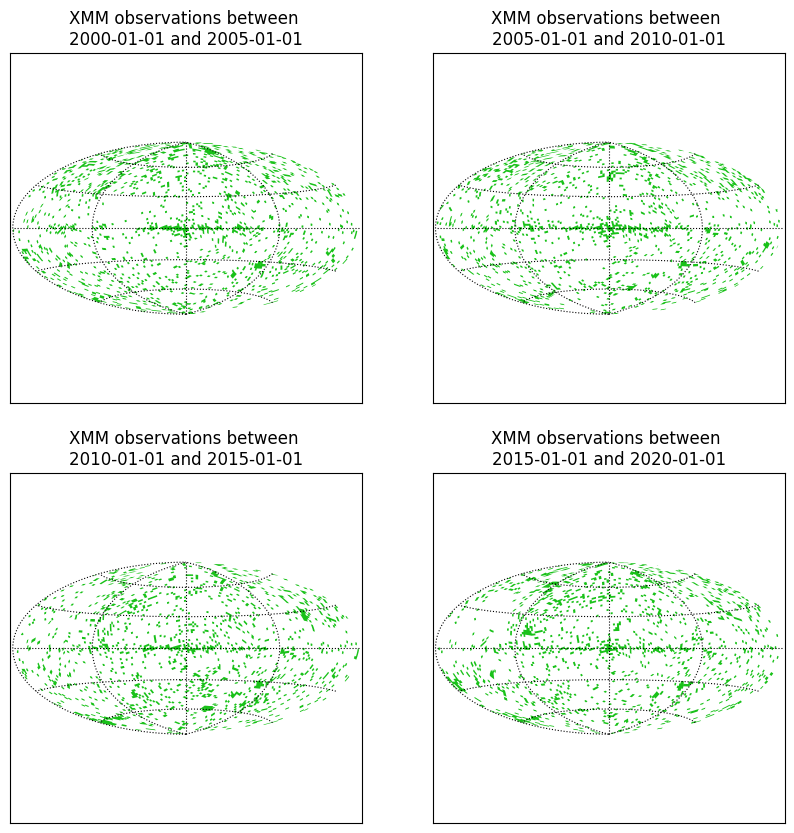

In [108]:
def add_to_plot(fig, label, wcs, title, moc):
    """Add a MOC to a plot."""
    ax = fig.add_subplot(label, projection=wcs)

    ax.grid(color="black", linestyle="dotted")
    ax.set_title(title)
    ax.set_xlabel("lon")
    ax.set_ylabel("lat")

    moc.fill(ax=ax, wcs=wcs, alpha=0.9, fill=True, linewidth=0, color="#00bb00")
    # moc.border(ax=ax, wcs=wcs, linewidth=1, color="green")


fig = plt.figure(figsize=(10, 10))

time_ranges = Time(
    [
        [["2000-01-01", "2005-01-01"]],
        [["2005-01-01", "2010-01-01"]],
        [["2010-01-01", "2015-01-01"]],
        [["2015-01-01", "2020-01-01"]],
    ],
    format="iso",
    scale="tdb",
    out_subfmt="date",
)
with WCS(
    fig,
    fov=330 * u.deg,
    center=SkyCoord(0, 0, unit="deg", frame="galactic"),
    coordsys="galactic",
    rotation=Angle(0, u.degree),
    projection="AIT",
) as wcs:
    for i in range(0, 4):
        tmoc = TimeMOC.from_time_ranges(
            min_times=time_ranges[i][0, 0],
            max_times=time_ranges[i][0, 1],
            delta_t=TimeDelta(0.5, scale="tdb", format="jd"),
        )

        moc_2mass = stmoc_xmm.query_by_time(tmoc)
        title = "XMM observations between \n{} and {}".format(
            time_ranges[i][0, 0].iso,
            time_ranges[i][0, 1].iso,
        )
        id_subplot = int("22" + str(i + 1))
        add_to_plot(fig, id_subplot, wcs, title, moc_2mass)
        aladin.add_moc(moc_2mass, fill=True, opacity=0.2, edge=True)

plt.show()

## Now fermi grb

#
The same process can be repeated for Fermi 

In [87]:
fermi_grb_metacat = tap_vizier.search("""select * from METAcat
                              where title like '%Fermi%GRB%'
                              """).to_table()
fermi_grb_metacat


catid,kslot,status,catype,name,title,bibcode,authors,explain,popu,authid,flags,doi,orcid,artdoi
int32,int16,int16,int16,object,object,object,object,object,int32,int32,int32,object,object,object
18930046,54,0,2,J/ApJ/893/46,"The fourth Fermi-GBM GRB catalog: 10 years (von Kienlin+, 2020)",2020ApJ...893...46V,"von Kienlin A., Meegan C.A., Paciesas W.S., et al.",,-1,0,0,10.26093/cds/vizier.18930046,0000-0002-0221-5916,10.3847/1538-4357/ab7a18
18730060,8,0,2,J/ApJ/873/60,"Improved Fermi-GBM GRB localizations using BALROG (Berlato+, 2019)",2019ApJ...873...60B,"Berlato F., Greiner J., Burgess J.M.",,-1,0,0,,0000-0001-8747-0627,10.3847/1538-4357/ab0413
35570100,51,0,5,J/A+A/557/A100,"Fermi and Swift GRBs E_peak_-E_iso_ relation (Heussaff+, 2013)",2013A&A...557A.100H,"Heussaff V., Atteia J.-L., Zolnierowski Y.",,1774,0,0,10.26093/cds/vizier.35570100,,10.1051/0004-6361/201321528
19150086,24,0,2,J/ApJ/915/86,"Swift & Fermi GRBs with LIGO-Virgo run O3a data (Abbott+, 2021)",2021ApJ...915...86A,"Abbott R., Abbott T.D., Abraham S. et al. The LIGO Scientific Collaboration and the Virgo Collaboration.",,-1,0,0,10.26093/cds/vizier.19150086,,10.3847/1538-4357/abee15
18650153,43,0,2,J/ApJ/865/153,"Analysis of Fermi GRB data. IV. Spectral lags (Lu+, 2018)",2018ApJ...865..153L,"Lu R.-J., Liang Y.-F., Lin D.-B., Lu J., Wang X.-G., Lu H.-J., Liu H.-B., Liang E.-W., Zhang B.",,293,0,0,10.26093/cds/vizier.18650153,,10.3847/1538-4357/aada16
74900927,54,0,5,J/MNRAS/490/927,"Bayesian Fermi-GBM short GRB spectral catalogue (Burgess+, 2019)",2019MNRAS.490..927B,"Burgess J.M., Greiner J., Begue D., Berlato F.",,-1,0,0,,0000-0003-3345-9515,10.1093/mnras/stz2589
35880135,54,0,2,J/A+A/588/A135,"Fermi/GBM GRB time-resolved spectral catalog (Yu+, 2016)",2016A&A...588A.135Y,"Yu H.-F., Preece R.D., Greiner J., et al.",,43,0,0,10.26093/cds/vizier.35880135,,10.1051/0004-6361/201527509
74313608,54,0,2,J/MNRAS/431/3608,"BeppoSAX/GRBM and Fermi/GBM long GRBs (Dichiara+, 2013)",2013MNRAS.431.3608D,"Dichiara S., Guidorzi C., Amati L., Frontera F.",,1071,0,0,10.26093/cds/vizier.74313608,,10.1093/mnras/stt445
22110013,54,0,2,J/ApJS/211/13,"The second Fermi/GBM GRB catalog (4yr) (von Kienlin+, 2014)",2014ApJS..211...13V,"von Kienlin A., Meegan C.A., Paciesas W.S., et al.",,2205,0,0,10.26093/cds/vizier.22110013,,10.1088/0067-0049/211/1/13


In [88]:
fermi_grb_catid = 18930046

In [89]:
fermi_grb_tables = tap_vizier.search(f"""select * from METAtab where catid={fermi_grb_catid}
""").to_table()
fermi_grb_tables

name,dbname,dbaid,catid,tabid,notid,flags,equinox,epoch,cooframe,status,explain,comment,records,loadate,release,filename,cooprec,morexplain
,,,,,,,yr,yr,,,,,,,,,mas,
object,object,int16,int32,int16,int16,int16,int16,float64,int16,int16,object,object,int64,int32,int32,object,float32,object
J/ApJ/893/46/table4,c18930046t4,44,18930046,1,0,0,2000,--,5,0,GRB triggers: locations and trigger characteristics,,2360,673015251,709226047,/ftp/cats/J/ApJ/893/46/table4.dat,1800000.0,
J/ApJ/893/46/table5,c18930046t5,44,18930046,2,0,0,--,--,0,0,GRB durations (50-300keV),,2359,673015251,709226047,/ftp/cats/J/ApJ/893/46/table5.dat,--,
J/ApJ/893/46/table6,c18930046t6,44,18930046,3,0,0,--,--,0,0,GRB fluence & peak flux (10-1000keV),,2359,673015251,709226047,/ftp/cats/J/ApJ/893/46/table6.dat,--,
J/ApJ/893/46/table7,c18930046t7,44,18930046,4,0,0,--,--,0,0,GRB fluence & peak flux (50-300keV),,2359,673015251,709226047,/ftp/cats/J/ApJ/893/46/table7.dat,--,
J/ApJ/893/46/table3,c18930046t3,44,18930046,5,0,0,--,--,0,0,Trigger modification history,,995,673015251,709226047,/ftp/cats/J/ApJ/893/46/table3.dat,--,


In [90]:
fermi_grb_triggers_columns = tap_vizier.search("""select * from columns where table_name='J/ApJ/893/46/table4'""").to_table()
fermi_grb_triggers_columns

table_name,column_name,description,unit,ucd,utype,datatype,size,principal,indexed,std
object,object,object,object,object,object,object,int32,int32,int32,int32
J/ApJ/893/46/table4,recno,Record number assigned by the VizieR team. Should Not be used for identification.,,meta.record,,INTEGER,-1,0,0,1
J/ApJ/893/46/table4,Fermi,Trigger identifier (bnYYMMDDddd),,meta.id;meta.main,,CHAR(11),11,0,0,1
J/ApJ/893/46/table4,f_Fermi,[A-Cb-z] Flag on Fermi (1),,meta.code,,CHAR(1),1,0,0,1
J/ApJ/893/46/table4,GRB,Gamma-ray burst identifier (YYMMDDA),,meta.id,,CHAR(7),7,0,0,1
J/ApJ/893/46/table4,Obs,UT date of the observation; date added by CDS,s,time.epoch;obs,,INTEGER,-1,0,0,1
J/ApJ/893/46/table4,RAJ2000,Right Ascension in decimal degrees (J2000),deg,pos.eq.ra;meta.main,,DOUBLE,-1,1,2,1
J/ApJ/893/46/table4,DEJ2000,Declination in decimal degrees (J2000),deg,pos.eq.dec;meta.main,,DOUBLE,-1,1,2,1
J/ApJ/893/46/table4,Error,[0/68.1] Position error,deg,stat.error;pos,,DOUBLE,-1,0,0,1
J/ApJ/893/46/table4,Loc,Location source,,meta.note,,VARCHAR,-1,0,0,1


In [91]:
fermi_grb_durations_columns = tap_vizier.search("""select * from columns where table_name='J/ApJ/893/46/table5'""").to_table()
fermi_grb_durations_columns

table_name,column_name,description,unit,ucd,utype,datatype,size,principal,indexed,std
object,object,object,object,object,object,object,int32,int32,int32,int32
J/ApJ/893/46/table5,recno,Record number assigned by the VizieR team. Should Not be used for identification.,,meta.record,,INTEGER,-1,0,0,1
J/ApJ/893/46/table5,Fermi,Trigger identifier,,meta.id;meta.main,,CHAR(11),11,0,0,1
J/ApJ/893/46/table5,f_Fermi,Flag on Fermi (1),,meta.code,,CHAR(2),2,0,0,1
J/ApJ/893/46/table5,Det,Detectors Used,,meta.id;instr,,VARCHAR,-1,0,0,1
J/ApJ/893/46/table5,T90,[0.008/829] Duration between 5% and 95% of maximum fluence,s,time.interval,,DOUBLE,-1,0,0,1
J/ApJ/893/46/table5,e_T90,[0.02/54] Uncertainty in T90,s,stat.error,,DOUBLE,-1,0,0,1
J/ApJ/893/46/table5,T90st,[-808/189] Start of T_90_ burst duration,s,time.start,,DOUBLE,-1,0,0,1
J/ApJ/893/46/table5,T50,[0.008/737] Duration between 25% and 75% of maximum fluence,s,time.interval,,DOUBLE,-1,0,0,1
J/ApJ/893/46/table5,e_T50,[0.01/40] Uncertainty in T50,s,stat.error,,DOUBLE,-1,0,0,1


In [92]:
# lets get metatime for the trigger table (tabid=1)
fermi_triggers_time_info = tap_vizier.search(
    f"""select * from METAtime JOIN METAcol
    on METAtime.catid = METAcol.catid
    and METAcol.colid = METAtime.colid
    and METAcol.tabid = METAtime.tabid
    where METAcol.catid = {fermi_grb_catid} and METAcol.tabid = 1
    """
).to_table()
fermi_triggers_time_info


catid,tabid,colid,time_syst_id,scale_name,frame_name,time_systematic_err,name,description,time_offset,time_uncertainty,time_representation,id,name2,dbname,catid2,tabid2,colid2,notid,famid,ucdid,type,dbtype,length,flags,morid,fmt,unit,dbunit,vounit,explain,morexplain,utype
int32,int16,int16,int32,object,object,float64,object,object,float64,float64,object,int16,object,object,int32,int16,int16,int16,int16,int32,int16,int16,int32,int16,int16,object,object,object,object,object,object,object
18930046,1,4,14,UT,,1000.0,UT_default,default UT scale frame,--,--,ISO,15120,Obs,Obs,18930046,1,4,0,1363,92530,16,40,4,131,0,%19T,s,s,s,UT date of the observation; date added by CDS,,


In [93]:
# let's query the joined tables (to get event start time and duration)
fermi = tap_vizier.search(
    """select * from "J/ApJ/893/46/table5"
    join "J/ApJ/893/46/table4" USING(Fermi)
    """
).to_table()
fermi

Fermi,recno,f_Fermi,Det,T90,e_T90,T90st,T50,e_T50,T50st,recno2,f_Fermi2,GRB,Obs,RAJ2000,DEJ2000,Error,Loc,Al,Time,Energy,Other
,,,,s,s,s,s,s,s,,,,s,deg,deg,deg,,,ms,keV,
object,int32,object,object,float64,float64,float64,float64,float64,float64,int32,str1,object,int32,float64,float64,float64,object,int16,int16,object,object
bn170110967,1990,,3+4+6+7+8,34.048,12.554,-0.256,25.856,1.28,1.024,1991,,,537405171,49.6,12.1,7.2,"Fermi, GBM FSW",11,512,47-291,
bn120412920,903,,2+5,101.182,4.871,0.003,11.264,0.572,71.745,903,,120412B,387583481,38.9,7.1,2.8,Fermi-GBM,9,256,47-291,K
bn080714086,1,,3+4+8,5.376,2.36,-0.768,2.816,0.81,-0.256,1,,080714B,269316252,41.9,8.5,7.5,Fermi-GBM,10,512,47-291,K
bn170305256,2038,b,0+1+2,0.448,0.072,-0.032,0.128,0.045,0.032,2039,,170305A,542009347,38.7,12.1,3.7,"Fermi, GBM FSW",1,16,47-291,"K, IA, P, ARR"
bn091005679,320,,6+7+8+11,6.976,0.572,-4.672,3.136,0.73,-1.984,320,,091005A,308074650,43.1,12.1,5.1,Fermi-GBM,12,1024,47-291,
bn140414693,1350,,0+1+3+4+5,25.6,2.202,-11.776,7.424,0.724,1.28,1350,,,450808718,45.7,13.8,2.3,Fermi-GBM,8,256,47-291,
bn100206563,394,g,0+1+2+3+5,0.176,0.072,-0.016,0.064,0.023,0.0,394,,100206A,318778205,47.2,13.2,0.0,Swift,1,16,47-291,"K, IA, S, W, ARR"
bn130912358,1225,,7+8+11,0.512,0.143,-0.064,0.256,0.143,-0.064,1225,,130912A,432290098,47.6,14.0,0.0,Swift,1,16,47-291,"S, K"


In [94]:
# we have to define a specific time for vizier 

from astropy.time.formats import erfa, TimeFromEpoch
class TimeVizier(TimeFromEpoch):
    name = "viztime"
    unit = 1.0 / erfa.DAYSEC  # in days (1 day == 86400 seconds)
    epoch_val = "2000-01-01 00:00:00"
    epoch_val2 = None
    epoch_scale = "utc"
    epoch_format = "iso"

In [95]:
fermi["start_time"] = Time(fermi["Obs"] - erfa.DAYSEC / 2., format="viztime", scale="utc")
fermi["end_time"] = Time(fermi["Obs"] + erfa.DAYSEC / 2., format="viztime", scale="utc")
fermi

Fermi,recno,f_Fermi,Det,T90,e_T90,T90st,T50,e_T50,T50st,recno2,f_Fermi2,GRB,Obs,RAJ2000,DEJ2000,Error,Loc,Al,Time,Energy,Other,start_time,end_time
,,,,s,s,s,s,s,s,,,,s,deg,deg,deg,,,ms,keV,,,
object,int32,object,object,float64,float64,float64,float64,float64,float64,int32,str1,object,int32,float64,float64,float64,object,int16,int16,object,object,Time,Time
bn170110967,1990,,3+4+6+7+8,34.048,12.554,-0.256,25.856,1.28,1.024,1991,,,537405171,49.6,12.1,7.2,"Fermi, GBM FSW",11,512,47-291,,537361971.0,537448371.0
bn120412920,903,,2+5,101.182,4.871,0.003,11.264,0.572,71.745,903,,120412B,387583481,38.9,7.1,2.8,Fermi-GBM,9,256,47-291,K,387540281.0,387626681.0
bn080714086,1,,3+4+8,5.376,2.36,-0.768,2.816,0.81,-0.256,1,,080714B,269316252,41.9,8.5,7.5,Fermi-GBM,10,512,47-291,K,269273052.0,269359452.0
bn170305256,2038,b,0+1+2,0.448,0.072,-0.032,0.128,0.045,0.032,2039,,170305A,542009347,38.7,12.1,3.7,"Fermi, GBM FSW",1,16,47-291,"K, IA, P, ARR",541966147.0,542052547.0
bn091005679,320,,6+7+8+11,6.976,0.572,-4.672,3.136,0.73,-1.984,320,,091005A,308074650,43.1,12.1,5.1,Fermi-GBM,12,1024,47-291,,308031450.0,308117850.0
bn140414693,1350,,0+1+3+4+5,25.6,2.202,-11.776,7.424,0.724,1.28,1350,,,450808718,45.7,13.8,2.3,Fermi-GBM,8,256,47-291,,450765518.0,450851918.0
bn100206563,394,g,0+1+2+3+5,0.176,0.072,-0.016,0.064,0.023,0.0,394,,100206A,318778205,47.2,13.2,0.0,Swift,1,16,47-291,"K, IA, S, W, ARR",318735005.0,318821405.0
bn130912358,1225,,7+8+11,0.512,0.143,-0.064,0.256,0.143,-0.064,1225,,130912A,432290098,47.6,14.0,0.0,Swift,1,16,47-291,"S, K",432246898.0,432333298.0


In [96]:
stmoc_fermi = STMOC.from_time_ranges_positions(
    times_start=fermi["start_time"],
    times_end=fermi["end_time"],
    lon = Longitude(fermi["RAJ2000"]),
    lat = Latitude(fermi["DEJ2000"]),
    time_depth=26, spatial_depth=5  # ask Ada why 5 here
)

# 
Now using the STMOC information for both XMM and Fermi, we can use intersection method to identify the common space-time regions covered by both Fermi and XMM-Newton observations. Additionally, all the events, that have been identified, are confirmed by two different telescopes, therefore we can know for certain that the GRBs identified are genuine. These give as output the time when both the telescopes with pointing at the same area of the sky. These come in handy specially for identifing simultaneous observations, which are crucial for multi-wavelength studies of transient events like Gamma-Ray Bursts (GRBs).

In [97]:
intersection = stmoc_fermi.intersection(stmoc_xmm)
intersection

t26/6172445 
s6/37910 
t26/6173274-6173275 
s6/16282 
t26/6176320 
s6/9576 
t26/6177369 
s6/17030 
t26/6177448 
s6/26013 

In [100]:
moc = intersection.query_by_time(TimeMOC.from_time_ranges(Time("1800-01-01"), Time("2050-01-01")))

/home/manon.marchand/.conda/envs/cds-tutos-dev/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/manon.marchand/.conda/envs/cds-tutos-dev/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/manon.marchand/.conda/envs/cds-tutos-dev/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [101]:
aladin.add_moc(moc)

By now we have seen the power of using STMOCs to identifying transients events such as GRBs. This method can also be applied for 
different astrophysical objects such as supernova remnants which emit at different wavelengths. STMOCs is a powerful tool which
facilitates the identification of temporal and spatial overlaps, enabling comprehensive multi-wavelength analyses and efficient data management, ultimately advancing our understanding of the object
of interest.

In [ ]:
hess = "J/A+A/612/A3"
super_nova_remnant = "RX J1713.7-3946"

In [ ]:
from astroquery.simbad import Simbad

In [ ]:
Simbad.query_object("RX J1713.7-3946")

In [ ]:
help(intersection.contains)

In [98]:
only_space = MOC.from_string("6/37910 16282 9576 17030 26013")

In [ ]:
from astropy.coordinates import Longitude, Latitude

In [ ]:
only_space.contains_lonlat(lon=Longitude("17 12 27", unit="deg"), lat=Latitude("-39 41.2", unit="deg"))

In [ ]:
only_space.query_vizier_table("J/A+A/612/A3")

In [ ]:
fermi_grbs_intersection = only_space.query_vizier_table("J/ApJ/893/46")
fermi_grbs_intersection

In [ ]:
aladin.add_table(fermi_grbs_intersection, color="hotpink", shape="cross")

In [ ]:
simbad = Simbad()
simbad.add_votable_fields("flux")

In [ ]:
simbad_result = simbad.query_objects([f"Fermi {id}" for id in fermi_grbs_intersection["Fermi"]])
simbad_result

In [ ]:
only_space.query_vizier_table("IX/69")